In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from fastai import *
from fastai.tabular import *
from fastai.callbacks import *
from fastai.text import *
from fastai.data_block import *
from fastai.metrics import *
from sklearn.model_selection import StratifiedKFold
import pickle
from fastprogress import master_bar, progress_bar
from IPython.display import FileLink
from sklearn.decomposition import PCA
import time
from swallows.training import *

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [53]:
model_name = 'tab-v4-tuning-3'

In [5]:
path=Path('data')

In [6]:
df_raw = pd.read_parquet(path/'processed/training_stage_1.parquet')
df_raw_test = pd.read_parquet(path/'processed/public_test_features_stage_1.parquet')

In [7]:
# TODO: move to py
def add_date_features(df):
    df = df.copy()
    for i in [7,14,21,30]:
        df[f'assigned_date_mod_{i}'] = np.mod(df['assigned_date'], i)
        df[f'create_date_mod_{i}'] = np.mod(df['create_date'], i)
    # TODO: fix rows when assinged date < create_date
    t1 = np.abs(df['assigned_date'] - df['create_date']) # some tickets has assinged date < create_date
    t2 = np.abs(df['create_date'] - df['assigned_date'])
    df['create_to_assigned_lag'] = np.minimum(t1, t2)
    # TODO add bins
    df['create_to_assigned_lag_log'] = np.log(df['create_to_assigned_lag'] + 1).astype(np.float)
    df['create_to_assigned_lag_log_bin'] = np.floor(df['create_to_assigned_lag_log']).astype(np.int)
    return df

In [8]:
df_train = add_date_features(df_raw)
df_test = add_date_features(df_raw_test)

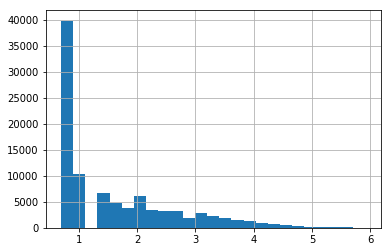

In [9]:
df_train[df_train['create_to_assigned_lag_log']>0]['create_to_assigned_lag_log'].hist(bins=25)

In [10]:
df_raw['root_cause'] = df_raw['root_cause'].fillna('')

In [11]:
df_root_cause_counts = pd.DataFrame(df_raw.groupby(['root_cause']).size().sort_values(ascending=False), columns=['count'])

Dataset has long tail of low-populated categories

In [12]:
min_size = 500
large_cats = df_root_cause_counts[df_root_cause_counts["count"] > min_size]
total_count = int(df_root_cause_counts.sum())
total_big_enough_covered =float(large_cats.sum()*100/df_root_cause_counts.sum())
print(f'Total cats: {len(df_root_cause_counts)} with {total_count} items')
print(f'cats w/ >{min_size} items: {len(large_cats)} with {total_big_enough_covered:.2f}% coverage')

Total cats: 960 with 1156151 items
cats w/ >500 items: 81 with 97.40% coverage


# Simple tabular NN

In [13]:
exclude_from_cats = [
    'ID', 
    'assigned_date',
    'create_date',
    'details',
    'short_description',
    'amazon_domains',
    'root_cause',
    'create_to_assigned_lag'
    'create_to_assigned_lag_log',
    'amz_domain_',
    'has_otheramzlink'
]

cat_names = [c for c in df_raw.columns if c not in exclude_from_cats]
cont_names = [] #['create_to_assigned_lag_log']
dep_var = 'root_cause'
procs = [FillMissing, Categorify, Normalize]

In [14]:
test = TabularList.from_df(df_test[cat_names + cont_names], path=path, cat_names=cat_names, cont_names=cont_names)

In [15]:
train_data = df_train[df_train['root_cause'].isin(large_cats.reset_index()['root_cause'])]
train_data = train_data[cat_names + cont_names + [dep_var]]

In [23]:
# splits_idxs = [s for s in gen_splits(10, train_data, 'root_cause')]
# pickle.dump(splits_idxs, open(path/f'{model_name}_cv_splits-10.pkl', "wb"))

In [16]:
splits_idxs = pickle.load(open(path/f'{model_name}_cv_splits-10.pkl', "rb"))
split = splits_idxs[7]

In [17]:
data = (TabularList.from_df(train_data, 
                            path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idxs(split[0], split[1])
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch(bs=2048))

In [55]:
learn = tabular_learner(data, layers=[727,353], metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


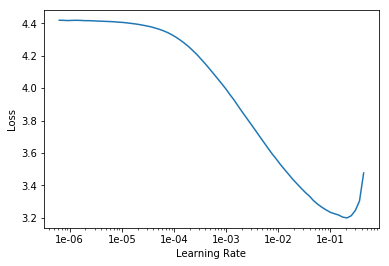

In [52]:
learn.lr_find(); learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.831212,1.877837,0.431699,01:45
1,1.788318,1.805066,0.447010,01:45
2,1.746422,1.755564,0.459662,01:45
3,1.698572,1.714286,0.466933,01:45
4,1.662715,1.694963,0.468858,01:45
5,1.620843,1.676496,0.475000,01:45
6,1.575326,1.658804,0.479048,01:45
7,1.523843,1.652826,0.483140,01:45
8,1.481511,1.658570,0.483408,01:45
9,1.453856,1.663019,0.483659,01:45


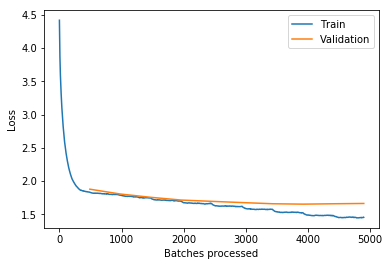

In [56]:
learn.fit_one_cycle(10, 1e-2); learn.recorder.plot_losses()

In [57]:
learn.save(f'{model_name}-fitted')

### Predictions

In [58]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [59]:
pred_classes = [data.classes[cls] for cls in np.argmax(preds[0].numpy(), axis=1)]

In [60]:
df_out = pd.DataFrame({'ID': df_raw_test['ID'], 'root_cause': pred_classes})

In [61]:
t = time.strftime('%Y_%m_%d_%H_%M')
out_fname = path/f'mle_ops_tech_naive_{t}_{model_name}.csv'
df_out.to_csv(out_fname, index=False)
FileLink(out_fname)

/home/ec2-user/2019-ops-it-challenge/data/mle_ops_tech_naive_2019_04_25_04_40_tab-v4-tuning-3.csv

* public leaderboard:  0.468457741163

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

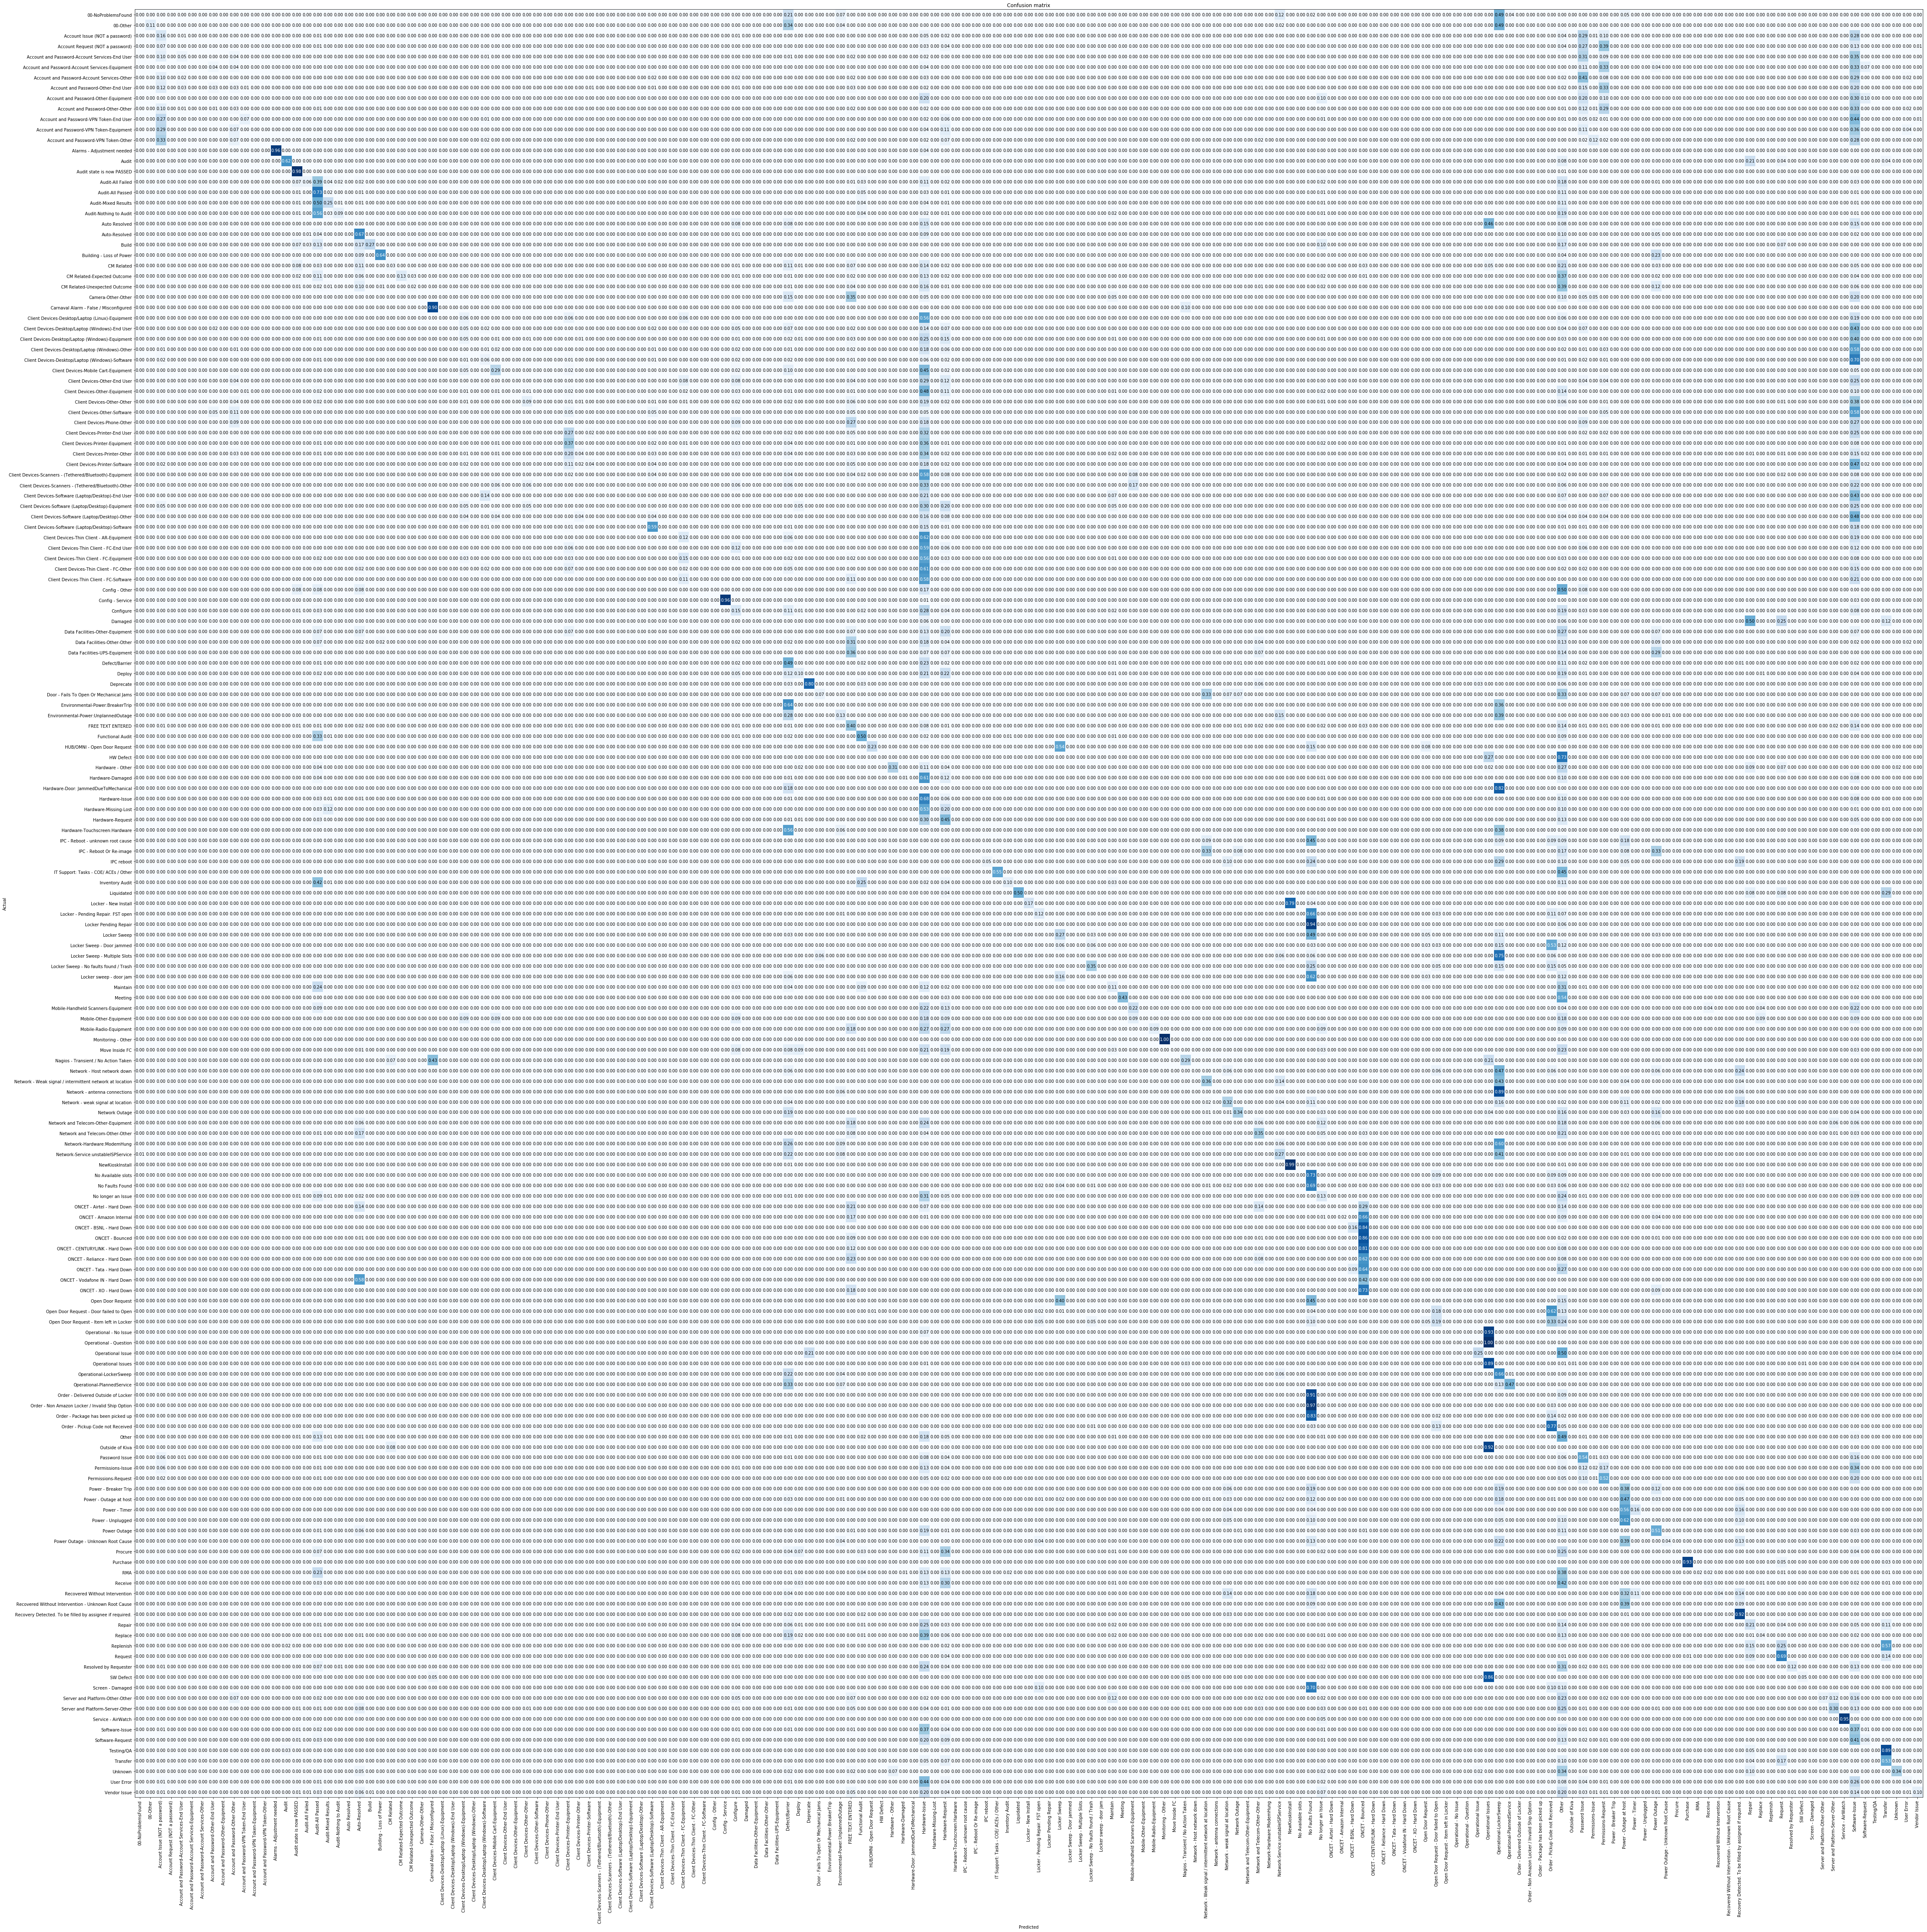

In [38]:
interp.plot_confusion_matrix(figsize=(64,64), normalize=True)

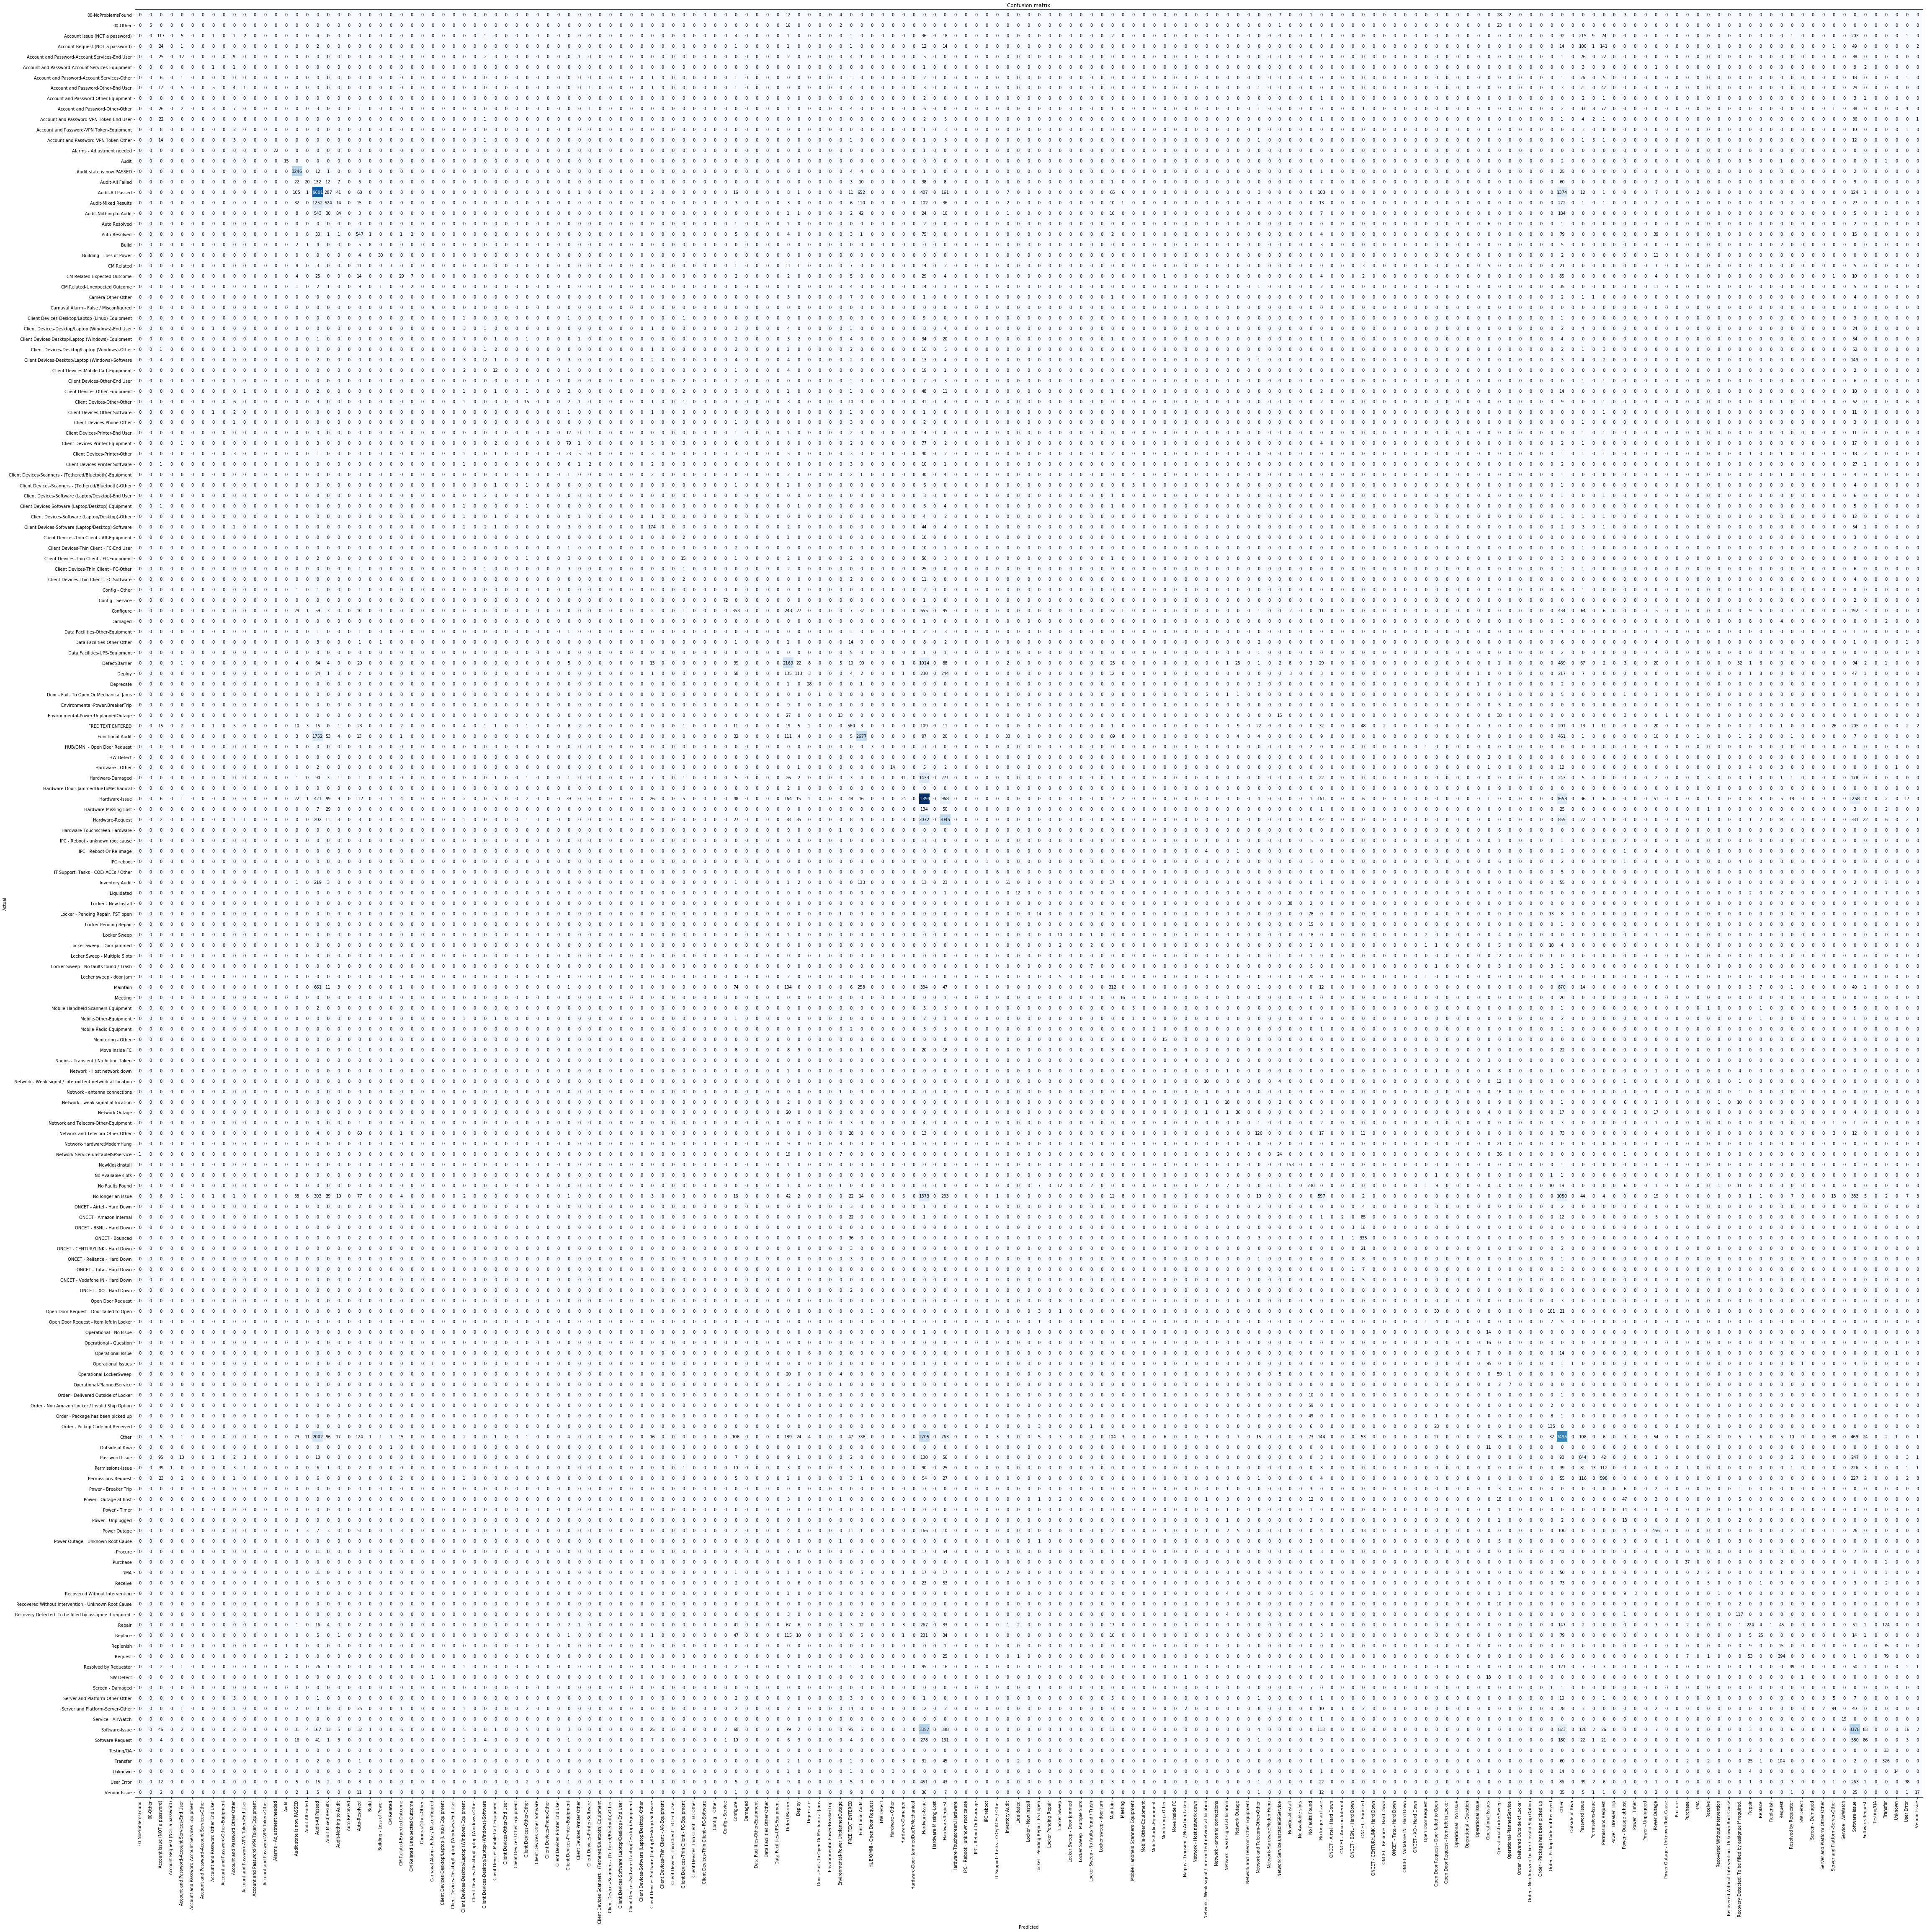

In [39]:
interp.plot_confusion_matrix(figsize=(64,64))